torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


/home/bohan/anaconda3/envs/ddgan_c/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


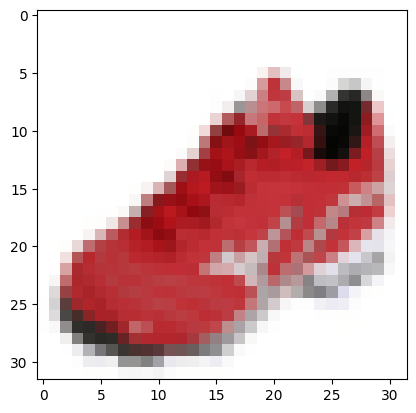

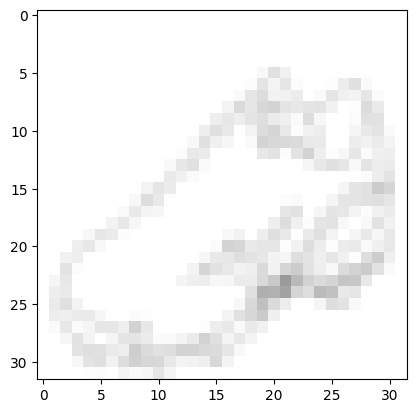

In [1]:
import torch
from datasets_prep.edges2shoes import Edge2Shoes
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

dataset = Edge2Shoes("/mnt/c/Users/Public/Documents/Datasets/edge2shoes", 4, 32, device="cuda:0", split="train")
# 获取一个批次的数据
x, y = dataset[45]
print(x.shape)
print(y.shape)
# 打印图像和标签
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# 显示图像
imshow(x)
imshow(y)

In [92]:
def q_sample_BBDM(x_start, y, t, T, noise=None):
    m_t = t / T
    m_t = m_t.unsqueeze(1).unsqueeze(2)
    delta_t = 2 * (m_t - m_t ** 2)
    noise = torch.rand_like(x_start, device=x_start.device)
    # print(f"xstart shape: {x_start.shape}")
    # print(f"y shape: {y.shape}")
    # print(f"t_menus_1 shape: {t_menus_1.shape}")
    # print(f"delta_t_menus_1 shape: {delta_t_menus_1.shape}")
    x_t = (1 - m_t) * x_start + m_t * y + delta_t ** 0.5 * noise
    return x_t, m_t, delta_t

def q_sample_pairs_for_BBDM(x_start, y ,t_menus_1,T):

    assert y is not None, 'Condition is required for forward diffusion.'
    x_t_menus_1, m_t_menus_1, delta_t_menus_1 = q_sample_BBDM(x_start, y, t_menus_1, T)
    t = t_menus_1 + 1
    print(f"t:{t}")
    m_t = t / T
    m_t = m_t.unsqueeze(1).unsqueeze(2)
    delta_t = 2 * (m_t - m_t** 2)
    noise = torch.rand_like(x_start, device=x_start.device)
    # print("===============")
    # print(f"xstart shape: {x_start.shape}")
    # print(f"y shape: {y.shape}")
    # print(f"t shape: {t.shape}")
    # print(f"delta_t shape: {delta_t.shape}")
    x_t = ((1 - m_t) / (1 - m_t_menus_1)) * x_t_menus_1 + (m_t - m_t_menus_1 * ((1 - m_t) / (1 - m_t_menus_1))) * y + (delta_t - delta_t_menus_1 * ((1 - m_t) ** 2 / (1 - m_t_menus_1) ** 2)) ** 0.5 * noise
    return x_t_menus_1, x_t


In [93]:
device = 'cuda:0'
real_x = x.to(device, non_blocking=True)
real_y = y.to(device, non_blocking=True)
num_timesteps = 4

forward_process = [real_x.cpu()]
for i_menues_1 in range(0, num_timesteps):
    i_menues_1 = torch.tensor([i_menues_1], device=real_x.device)
    x_t, x_t = q_sample_pairs_for_BBDM(real_x, real_y, i_menues_1,num_timesteps)
    # if i_menues_1 % 100 == 0:
    #     print(i_menues_1)
    #     forward_process.append(x_t.cpu().detach())    
    forward_process.append(x_t.cpu().detach())  


forward_process.append(x_t.cpu().detach())

t = torch.tensor([0], device=real_x.device)
x_t, x_t = q_sample_pairs_for_BBDM(real_x, real_y, t,num_timesteps)
# imshow(x_t)
# imshow(x_t_menus_1)
# print(x_t)
# print(x_t_menus_1)

t:tensor([1], device='cuda:0')
t:tensor([2], device='cuda:0')
t:tensor([3], device='cuda:0')
t:tensor([4], device='cuda:0')
t:tensor([1], device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6


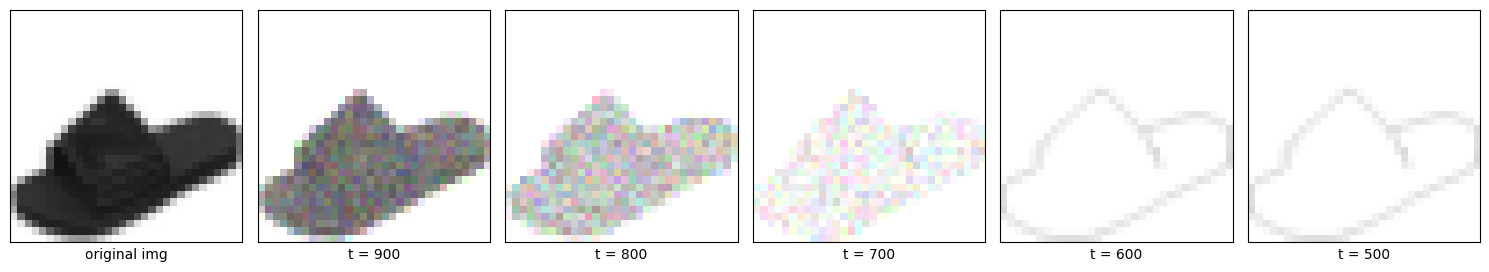

In [94]:
print(len(forward_process))
plt.figure(figsize=(15, 3))
for i_menues_1, image in enumerate(forward_process):
    img = image / 2 + 0.5  # unnormalize
    np_image = img.cpu().numpy()
    ax = plt.subplot(1, len(forward_process), i_menues_1 + 1)  
    ax.imshow(np.transpose(np_image, (1, 2, 0)))
    if(i_menues_1 == 0):
        ax.set_xlabel(f"original img")   
    else:
        ax.set_xlabel(f"t = {1000 - i_menues_1 * 100}")  
    ax.set_xticks([])  
    ax.set_yticks([])  
plt.tight_layout()
plt.show() 

In [ ]:
def sample_posterio_BBDM(x_0,x_t, y, t, T):
    # print(x_0.shape)
    # print(x_t.shape)
    # print(y.shape)
    # print(t)
    # print("========")
    def q_posterior_BBDM(x_0, x_t, y, t, T):

        m_t = t / T
        # m_t = torch.tensor([m_t], device=x_0.device)
        # m_t = m_t.unsqueeze(1).unsqueeze(2)

        # m_t_minus_one
        m_t_minus_one = (t-1) / T
        # m_t_minus_one = torch.tensor([m_t_minus_one], device=x_0.device)
        # m_t_minus_one = m_t_minus_one.unsqueeze(1).unsqueeze(2)

        # delta_t and delta_t_minus_one
        delta_t = 2 * (m_t - m_t ** 2)
        delta_t_minus_one = 2 * (m_t_minus_one - m_t_minus_one ** 2)
        delta_t_by_t_minus_one = delta_t - delta_t_minus_one * ((1 - m_t) ** 2) / ((1 - m_t_minus_one) ** 2)
        tilde_delta_t = delta_t_by_t_minus_one * delta_t_minus_one / delta_t

        # c_xt, c_yt, and c_epst
        c_xt = (delta_t_minus_one / delta_t) * (1 - m_t) / (1 - m_t_minus_one)
        c_yt = m_t_minus_one - m_t * (1 - m_t) / (1 - m_t_minus_one) * (delta_t_minus_one / delta_t)
        c_x0 = 1 - m_t_minus_one * delta_t_by_t_minus_one / delta_t



        mean = (
            c_xt * x_t + c_x0 * x_0 + c_yt * y
        )
        var = tilde_delta_t
        return mean, var
    
  
    def p_sample_BBDM(x_0, x_t, y, t, T):
        mean, var = q_posterior_BBDM(x_0, x_t, y, t, T)
        
        noise = torch.randn_like(x_t)
        
        nonzero_mask = (1 - (t == 1).type(torch.float32))

        return mean + nonzero_mask[:,None,None,None] * torch.exp(0.5 * var) * noise
            
    sample_x_pos = p_sample_BBDM(x_0, x_t, y, t, T)
    
    return sample_x_pos

def sample_from_model_BBDM(x_0, n_time, x_init, y):
    x = x_init
    x_steps = []
    # x_steps.append(x_init)
    with torch.no_grad():
        for i in reversed(range(1 , n_time)):
            t = torch.tensor([i], device=real_x.device)
            print(t)
            # latent_z = torch.randn([opt.nz], device=x.device)
            x_new = sample_posterio_BBDM(x_0, x, y, t, n_time)
            x_steps.append(x_new)
            x = x_new.detach()
    return x, x_steps

In [ ]:
fake_sample, x_steps = sample_from_model_BBDM(real_x, num_timesteps, real_y, real_y)
print(fake_sample.shape)
print(len(x_steps))
for i in range(len(x_steps)):
    # print(x_steps[i].shape)
    imshow(x_steps[i][0])

In [ ]:
from score_sde.models.ncsnpp_generator_adagn import NCSNpp
from argparse import Namespace

# 手动创建 args 对象
args = Namespace(
    seed=1024,
    resume=True,
    image_size=32,
    num_channels=3,
    centered=True,
    use_geometric=False,
    beta_min=0.1,
    beta_max=20.0,
    num_channels_dae=128,
    n_mlp=4,
    ch_mult=[1, 2, 2, 2],
    num_res_blocks=2,
    attn_resolutions=(16,),
    dropout=0.0,
    resamp_with_conv=True,
    conditional=True,
    fir=True,
    fir_kernel=[1, 3, 3, 1],
    skip_rescale=True,
    resblock_type='biggan',
    progressive='none',
    progressive_input='residual',
    progressive_combine='sum',
    embedding_type='positional',
    fourier_scale=16.0,
    not_use_tanh=False,
    exp='ddgan_edges2shoes_exp4',
    dataset='edges2shoes',
    nz=100,
    num_timesteps=4,
    z_emb_dim=256,
    t_emb_dim=256,
    batch_size=1,
    num_epoch=1000,
    ngf=64,
    lr_g=0.00016,
    lr_d=0.000125,
    beta1=0.5,
    beta2=0.9,
    no_lr_decay=False,
    use_ema=True,
    ema_decay=0.9999,
    r1_gamma=0.02,
    lazy_reg=15,
    save_content=True,
    save_content_every=50,
    save_ckpt_every=25,
    num_proc_node=1,
    num_process_per_node=1,
    node_rank=0,
    local_rank=0,
    master_address='127.0.0.1',
    world_size=1
)

# 使用手动创建的 args 对象
print(args)



In [79]:
def sample_from_model_BBDM_real(generator, n_time, x_init, opt, y):
    x = x_init
    x_0s = []
    with torch.no_grad():
        for i in reversed(range(1 , n_time)):
            t = torch.full((x.size(0),), i, dtype=torch.int64).to(x.device)
            t_time = t
            latent_z = torch.randn(x.size(0), opt.nz, device=x.device)
            print(x.shape)
            print(y.shape)
            print(t_time.shape)
            print(latent_z.shape)
            print("=====")
            x_0 = generator(x, t_time, latent_z, y)

            x_new = sample_posterior_BBDM(x_0, x, y, t, args.num_timesteps)
            x = x_new.detach()
            x_0s.append(x_0.clone())

    return x, x_0s

def sample_posterior_BBDM(x_0,x_t, y, t, T):
    
    def q_posterior_BBDM(x_0, x_t, y, t, T):
        m_t = t / T
        # m_t = torch.full((x_0.shape[0],), m_t, device=x_0.device)
        m_t = m_t.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # m_t_minus_one
        m_t_minus_one = (t - 1) / T
        # m_t_minus_one = torch.full((x_0.shape[0],), m_t_minus_one, device=x_0.device)
        m_t_minus_one = m_t_minus_one.unsqueeze(1).unsqueeze(2).unsqueeze(3)

        # delta_t and delta_t_minus_one
        delta_t = 2 * (m_t - m_t ** 2)
        delta_t_minus_one = 2 * (m_t_minus_one - m_t_minus_one ** 2)
        delta_t_by_t_minus_one = delta_t - delta_t_minus_one * ((1 - m_t) ** 2) / ((1 - m_t_minus_one) ** 2)
        tilde_delta_t = delta_t_by_t_minus_one * delta_t_minus_one / delta_t

        # c_xt, c_yt, and c_epst
        c_xt = (delta_t_minus_one / delta_t) * (1 - m_t) / (1 - m_t_minus_one)
        c_yt = m_t_minus_one - m_t * (1 - m_t) / (1 - m_t_minus_one) * (delta_t_minus_one / delta_t)
        c_x0 = 1 - m_t_minus_one * delta_t_by_t_minus_one / delta_t



        mean = (
            c_xt * x_t + c_x0 * x_0 + c_yt * y
        )
        var = tilde_delta_t
        return mean, var
    
  
    def p_sample_BBDM(x_0, x_t, t):
        mean, var = q_posterior_BBDM(x_0, x_t, y, t, T)
        
        noise = torch.randn_like(x_t)
        
        nonzero_mask = (1 - (t == 1).type(torch.float32))

        return mean + nonzero_mask[:,None,None,None] * torch.exp(0.5 * var) * noise
            
    sample_x_pos = p_sample_BBDM(x_0, x_t, t)
    
    return sample_x_pos

In [97]:
netG = NCSNpp(args).to(device)
ckpt = torch.load('saved_info/dd_gan/edges2shoes/ddgan_edges2shoes_exp4/netG_1000.pth', map_location=device)
for key in list(ckpt.keys()):
    ckpt[key[7:]] = ckpt.pop(key)
netG.load_state_dict(ckpt)
netG.eval()
save_dir = "./generated_samples/{}".format('edges2shoes')

x, y = dataset[-1]
real_y = y.to(device="cuda:0")
real_x = x.to(device="cuda:0")

x_T = real_y
x_T = x_T.unsqueeze(0)
fake_sample, x_0s = sample_from_model_BBDM_real(netG, args.num_timesteps, x_T, args, real_y)



torch.Size([1, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([1])
torch.Size([1, 100])
=====
torch.Size([1, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([1])
torch.Size([1, 100])
=====
torch.Size([1, 3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([1])
torch.Size([1, 100])
=====


torch.Size([1, 3, 32, 32])


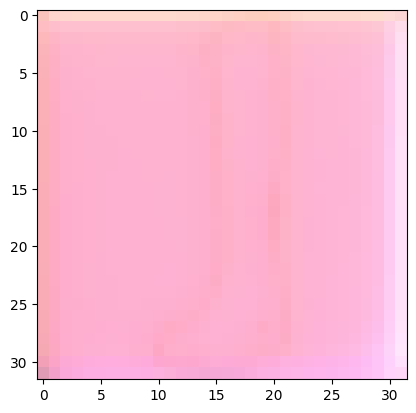

In [98]:
print(x_0s[0].shape)
imshow(x_0s[0][0])

t:tensor([2], device='cuda:0')
torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1, 100])
torch.Size([1])


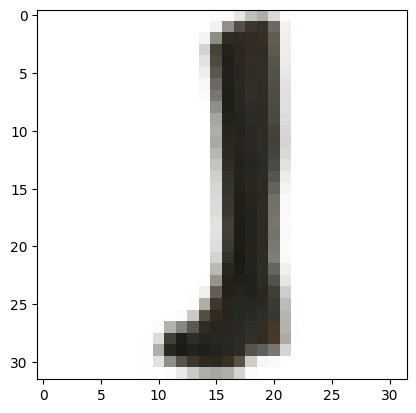

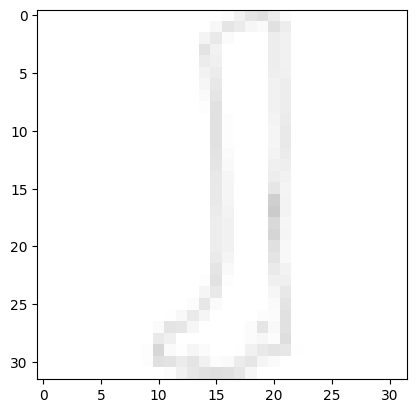

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


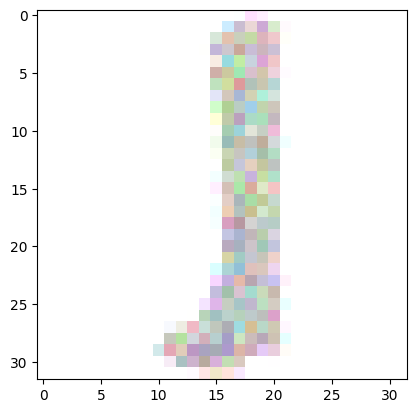

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


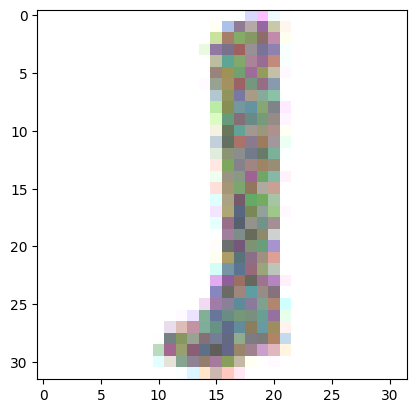

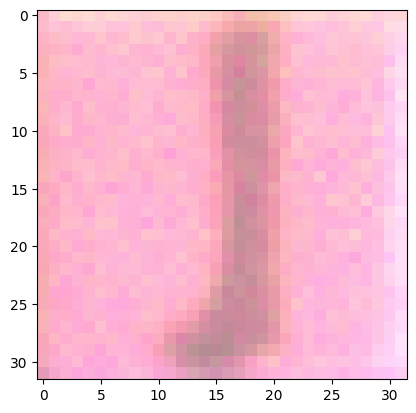

In [99]:
test_x = real_x.unsqueeze(0)
test_y = real_y.unsqueeze(0)
latent_z = torch.randn(test_y.size(0), args.nz, device=real_x.device)

i_menues_1 = torch.tensor([1], device=real_x.device)
x_t, x_t = q_sample_pairs_for_BBDM(test_x, test_y, i_menues_1,num_timesteps)


t = torch.full((test_x.size(0),), 2, dtype=torch.int64).to(real_y.device)

print(test_x.shape)
print(test_y.shape)
print(latent_z.shape)
print(t.shape)
x_0 = netG(x_t.to(device), t, latent_z, test_y.to(device))
imshow(test_x[0].detach())
imshow(test_y[0].detach())
imshow(x_t[0].detach())
imshow(x_t[0].detach())
imshow(x_0[0].detach())